In [1]:
from sklearn.datasets import fetch_openml
from sklearn import preprocessing
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display # to display images
import torchvision as thv
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import torch

In [2]:
def shuffle_dataset(X, Y):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    return X[indices], Y[indices]

def subsample(dataset, num_samples, num_classes):
    X = dataset.data.numpy()

    # flatten X and change type
    X = X.reshape(X.shape[0], -1).astype(np.float32)

    Y = np.array(dataset.targets)

    # final size of each class
    class_size = int(num_samples / 10)
    indices = []

    for label in range(num_classes):
        # find indices for the given label and select the first class_size elements
        label_indices = np.argwhere(Y == label)[:class_size].flatten()
        indices.extend(label_indices)

    indices = np.array(indices)
    sampled_X = X[indices]
    sampled_Y = Y[indices]

    # normalize x
    sampled_X = sampled_X / 255.0

    return sampled_X, sampled_Y

def batch_generator(X, Y, batch_size):
    while True:
        X, Y = shuffle_dataset(X, Y)
        for i in range((X.shape[0] - batch_size) // batch_size):
            yield X[i * batch_size: i * batch_size + batch_size], Y[i * batch_size: i * batch_size + batch_size]


In [3]:
np.random.seed(20)

# load dataset
train = thv.datasets.MNIST('./', download=True, train=True)
val = thv.datasets.MNIST('./', download=True, train=False)

trainX, trainY = subsample(dataset=train, num_samples=10*1000, num_classes=10)
valX, valY = subsample(dataset=val, num_samples=500*10, num_classes=10)

In [4]:
def resize_images(df, old, new):
    df_temp = df
    num_samples = df_temp.shape[0]
    df_temp = df_temp.reshape((num_samples, old, old))
    downsized = np.zeros((num_samples, new, new))
    for ix in range(num_samples):
        downsized[ix] = cv2.resize(df_temp[ix], (new, new))
        _, downsized[ix] = cv2.threshold(downsized[ix]*255,127,1,cv2.THRESH_BINARY)
    downsized = downsized.reshape((num_samples, new**2))
    return downsized

In [5]:
resized_train_x = resize_images(trainX, 28, 14)
resized_val_x = resize_images(valX, 28, 14)

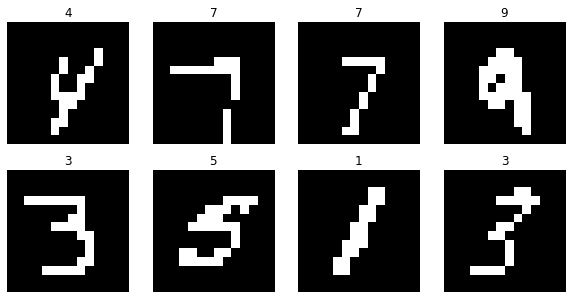

In [6]:
fig, axs = plt.subplots(2, 4, figsize=(10, 5))
index = np.random.randint(len(trainX), size=8)
i = 0

for r in range(2):
    for c in range(4):
        axs[r, c].imshow(resized_train_x[index[i]].reshape(14, 14),cmap=plt.cm.gray)
        axs[r, c].set_title(str(trainY[index[i]]))
        axs[r, c].axis('off')
        i+=1

In [7]:
BATCH_SIZE = 32
train_dataloader = batch_generator(resized_train_x, trainY, batch_size=BATCH_SIZE)
val_dataloader = batch_generator(resized_val_x, valY, batch_size=BATCH_SIZE)

In [8]:
def KL(mu, sigma):
    contribution = 1 + sigma - mu**2 - torch.exp(sigma)
    return (torch.sum(-contribution/2))
    
def AELoss(x, mu, sigma, decoding):
    kl_loss = KL(mu, sigma)
    
    bce =  F.binary_cross_entropy(decoding, x.view(-1, 196), reduction='sum')     
    return (kl_loss + bce, kl_loss, bce)

1. Two fully-connected layers
    - first has 196 inputs and 128 outputs + tanh nonlinearity
    - second has 128 inputs and 16 outputs + no nonlinearity
1. Decoder takes as an input z, pushes it through:
    - one layer with 128 outputs + tanh nonlinearity
    - another layer with 196 output neurons + sigmoid nonlinearity

In [9]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(196, 128)
        self.fc2 = nn.Linear(128, 16)
        self.fc3 = nn.Linear(128, 16)

    def forward(self, x):
        reshaped = x.reshape(x.shape[0], -1)
        out = torch.tanh(self.fc1(reshaped))
        fc2_out = self.fc2(out)
        fc3_out = self.fc3(out)
        
        mu = (fc2_out[:, :8] + fc3_out[:, :8])/2
        logvar = (fc2_out[:, 8:] + fc3_out[:, 8:])/2
        
        std = logvar.mul(0.5).exp_()
        eps1 = torch.randn_like(std)
        eps2 = torch.randn_like(std)
        eps = (eps1 + eps2)/2
        z = eps.mul(std).add_(mu)  
        return z, mu, logvar
        
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(8, 128)
        self.fc2 = nn.Linear(128, 196)

    def forward(self, x):
        out = torch.tanh(self.fc1(x))
        out = torch.sigmoid(self.fc2(out))
        return out

In [10]:
lr = 1.5e-2
epochs = 100
num_batches = (int)(len(resized_train_x)/BATCH_SIZE)
encoder = Encoder()
decoder = Decoder()

total_params = list(encoder.parameters())+list(decoder.parameters())
optimizer = optim.Adam(total_params, lr = lr)

In [11]:
train_error_list, train_loss_list, val_error_list, val_loss_list = [], [], [], []
bce_list, kl_list = [], []

In [12]:
 for epoch in range(epochs):
    for t in range(num_batches):
        x, y = train_dataloader.__next__()

        x = torch.Tensor(x)
        y = torch.Tensor(y).long()
        
        optimizer.zero_grad()

        z, mu, logvar = encoder(x)

        decoding = decoder(z)

        total_loss, kl, bce = AELoss(x, mu, logvar, decoding)
        total_loss.backward()

        optimizer.step()

        train_loss_list.append(total_loss.item()/BATCH_SIZE)
        kl_list.append(kl.item()/BATCH_SIZE)
        bce_list.append(bce.item()/BATCH_SIZE)
    
    print(epoch, kl_list[-1], bce_list[-1], train_loss_list[-1])

0 5.970338344573975 36.7484245300293 42.7187614440918
1 6.652314186096191 29.945341110229492 36.59765625
2 6.2325968742370605 28.89830207824707 35.130897521972656
3 7.929349899291992 30.252290725708008 38.181640625
4 7.217823028564453 30.45798110961914 37.675804138183594
5 6.649221897125244 29.02096939086914 35.67019271850586
6 7.120731830596924 30.139766693115234 37.260498046875
7 6.885329723358154 32.012733459472656 38.89806365966797
8 7.697041988372803 29.55803680419922 37.25507736206055
9 7.8362717628479 29.290987014770508 37.12725830078125
10 6.938119411468506 26.913299560546875 33.851417541503906
11 7.520765781402588 30.156282424926758 37.67704772949219
12 8.039457321166992 27.320308685302734 35.359764099121094
13 7.083981513977051 28.31285858154297 35.3968391418457
14 7.49996280670166 30.960033416748047 38.45999526977539
15 7.980931282043457 33.19676971435547 41.17770004272461
16 7.804154396057129 25.863801956176758 33.6679573059082
17 7.9815168380737305 28.21933937072754 36.200

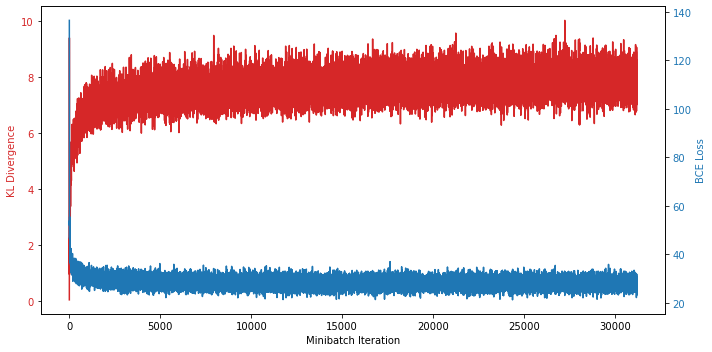

In [14]:
fig, ax1 = plt.subplots(figsize=(10, 5))

color = 'tab:red'
ax1.set_xlabel('Minibatch Iteration')
ax1.set_ylabel("KL Divergence", color=color)
ax1.plot(np.arange(len(kl_list)), kl_list, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel("BCE Loss", color=color)  # we already handled the x-label with ax1
ax2.plot(np.arange(len(bce_list)), bce_list, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

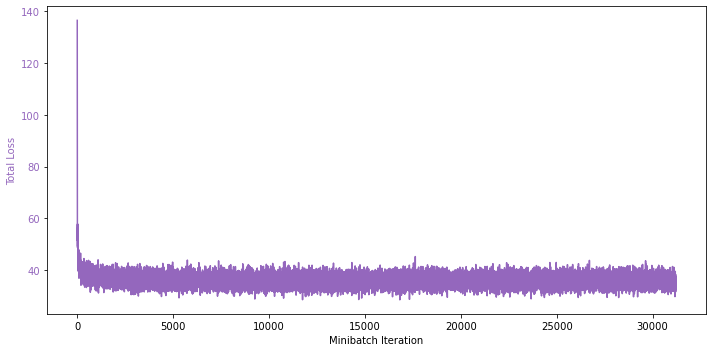

In [15]:
fig, ax1 = plt.subplots(figsize=(10, 5))

color = 'tab:purple'
ax1.set_xlabel('Minibatch Iteration')
ax1.set_ylabel("Total Loss", color=color)
ax1.plot(train_loss_list, color=color)
ax1.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

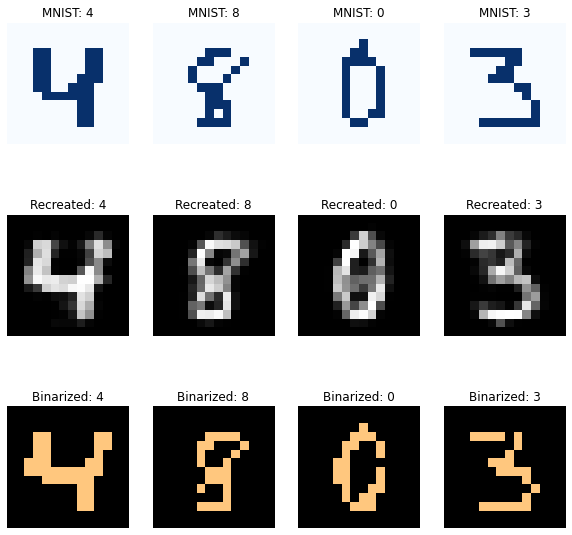

In [16]:
num_samples = 4
fig, axs = plt.subplots(3, num_samples,figsize=(10, 10))


index = np.random.randint(len(resized_val_x), size=8)
i = 0

for c in range(num_samples):
    x = resized_val_x[index[i]]
    axs[0, c].imshow(x.reshape(14, 14), cmap=plt.cm.Blues)
    axs[0, c].set_title("MNIST: " + str(valY[index[i]]))
    axs[0, c].axis('off')
    
    x = torch.Tensor(x).unsqueeze(0)
    
    
    z, mu, sigma = encoder(x)
    
    decoding = decoder(z)
    
    decoding = decoding.reshape((14, 14)).detach().numpy()
    
    axs[1, c].imshow(decoding, cmap=plt.cm.gray)
    axs[1, c].set_title("Recreated: " + str(valY[index[i]]))
    axs[1, c].axis('off')
    
    _, binarized = cv2.threshold(decoding*255,127,255,cv2.THRESH_BINARY)
    axs[2, c].imshow(binarized, cmap=plt.cm.copper)
    axs[2, c].set_title("Binarized: " + str(valY[index[i]]))
    axs[2, c].axis('off')
    
    i+=1
plt.show()    

In [17]:
randoms = np.array([np.random.normal(0, 1, 8) for _ in range(BATCH_SIZE)])
randoms.reshape((BATCH_SIZE, 8)).astype(np.float32)
randoms = torch.tensor(randoms)

decoding = decoder(randoms.float())
decoding = decoding.reshape((BATCH_SIZE, 14, 14)).detach().numpy()
_, binarized = cv2.threshold(decoding*255,127,255,cv2.THRESH_BINARY)

In [18]:
num_pics = 10

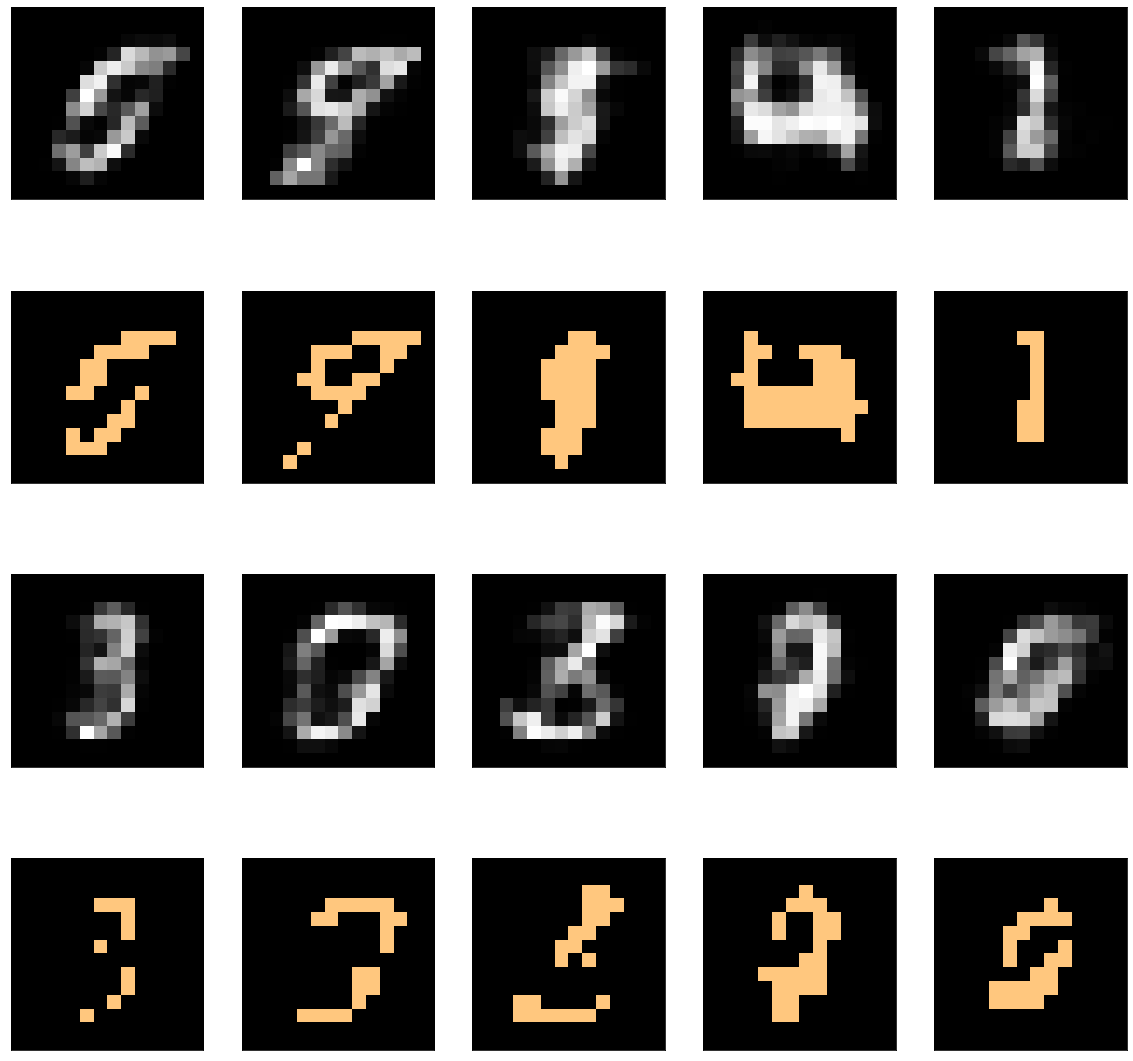

In [19]:
fig, axes = plt.subplots(ncols=int(num_pics/2), nrows=4, figsize=(20, 20),
                             subplot_kw={'xticks': [], 'yticks': []})
for i in range(num_pics):
    axes[2*(i // int(num_pics/2)), i % int(num_pics/2)].imshow(decoding[i], cmap='gray')
    axes[2*(i // int(num_pics/2)) + 1, i % int(num_pics/2)].imshow(binarized[i], cmap='copper')